# Rede neural para idade

## Configurando o treinamento

In [5]:
import numpy as np 

model_path = 'models/'
data_dir = 'data/'
data_path = data_dir + 'train_test/'

model_name = 'idade'

n_epochs = 50
patience = 5
input_shape = (75,75,1)
output_shape = 1

## Carregando os dados

In [3]:
from PIL import Image
import os 

def load_data(data_type):
    
    if data_type == 'train':
        data_tag = '0'
    elif data_type == 'valid':
        data_tag = '1'
    else:
        data_tag = '2'
        
    files = os.listdir(data_path)    
    files = [file for file in files if file.split('.')[0] == data_tag]
    
    y = np.array([int(file.split('.')[3].split('_')[0]) for file in files])
    
    files = [data_path + file for file in files] 
    x = [np.array(Image.open(file)) for file in files]
    x = [(image - image.min())/(image.max()-image.min()) for image in x]
    x = np.expand_dims(x, axis=3)
    
    return x,y

In [4]:
X_train, y_train = load_data('train')
X_val, y_val = load_data('valid')

## A rede neural

In [6]:
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Dropout(0.2))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Dropout(0.2))

model.add(Flatten()) 
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization(input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(output_shape, activation='relu'))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
)

Instructions for updating:
Colocations handled automatically by placer.


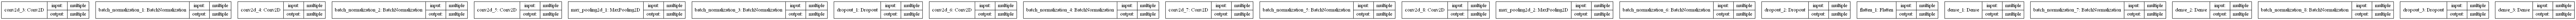

In [7]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image as im

data= plot_model(model, show_shapes=True, show_layer_names=True)
im('model.png')

## Treinamento inicial

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        model_path+model_name+'_{loss:.3f}-{val_loss:.3f}-{epoch:02d}.h5',
        monitor='val_loss',
        verbose=1,
        save_best_only=True),
    EarlyStopping('val_loss',patience = patience),
]

history = model.fit(
        x = X_train,y=y_train,
        epochs=n_epochs,
        validation_data=(X_val,y_val),
        callbacks=callbacks
)

Train on 14151 samples, validate on 6604 samples
Epoch 1/50
14151/14151 [==============================] - 50s 4ms/step - loss: 520.6254 - val_loss: 264.8247

Epoch 00001: val_loss improved from inf to 264.82473, saving model to models/idade_520.625-264.825-01.h5
Epoch 2/50
14151/14151 [==============================] - 46s 3ms/step - loss: 174.7867 - val_loss: 286.8507

Epoch 00002: val_loss did not improve from 264.82473
Epoch 3/50
14151/14151 [==============================] - 45s 3ms/step - loss: 116.6139 - val_loss: 110.8252

Epoch 00003: val_loss improved from 264.82473 to 110.82515, saving model to models/idade_116.614-110.825-03.h5
Epoch 4/50
14151/14151 [==============================] - 45s 3ms/step - loss: 101.1956 - val_loss: 97.4063

Epoch 00004: val_loss improved from 110.82515 to 97.40629, saving model to models/idade_101.196-97.406-04.h5
Epoch 5/50
14151/14151 [==============================] - 45s 3ms/step - loss: 93.1042 - val_loss: 87.6900

Epoch 00005: val_loss impr

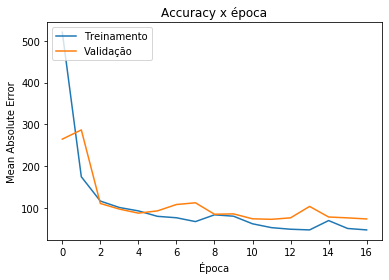

In [8]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy x época')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

## Selecionando o melhor modelo

In [9]:
from keras.models import load_model

model = load_model('models/idade_83.693-85.065-09.h5')

## Ajustando o treinamento com o dataset de validação

In [10]:
from keras.models import load_model
model.fit(
    x = X_val,
    y=y_val,
    epochs=1,
)

Epoch 1/1
6604/6604 [==============================] - 21s 3ms/step - loss: 92.9518


## Testando contra o dataset de teste


In [11]:
X_test, y_test = load_data('test')

#### Juntando dados de treinamento e validação em um único dataset para comparação

In [12]:
X_train = np.append(X_train,X_val,axis=0)
y_train = np.append(y_train,y_val,axis=0)

del X_val, y_val

In [13]:
loss_train = model.evaluate(x=X_train, y=y_train, verbose=1)
loss_test = model.evaluate(x=X_test, y=y_test, verbose=1)

print('CNN:')
print("MSE treinamento", np.round(loss_train,3))
print("MSE teste", np.round(loss_test,3))

2831/2831 [==============================] - 2s 871us/step
CNN:
MSE treinamento 52.877
MSE teste 71.605


#### Comparando com modelos dummy

Estragégia dummy 1: chutar a média dos valores <br>
Estragégia dummy 2: chute aleatório

In [15]:
np.mean(y_train),np.max(y_train),np.min(y_train)

(33.27569260419176, 116, 1)

In [16]:
from sklearn.metrics import mean_squared_error

def evaluate(train_pred,test_pred):
    
    loss_train = mean_squared_error(y_train,train_predictions)
    loss_test = mean_squared_error(y_test,test_predictions)
    
    print("MSE treinamento", np.round(loss_train,3))
    print("MSE teste", np.round(loss_test,3))
    print()
    
    
mean = 33
train_predictions = [mean] * y_train.shape[0]
test_predictions = [mean] * y_test.shape[0]
print('Estratégia 1 (média):')
evaluate(train_predictions,test_predictions)

y_max = 116
y_min = 1
train_predictions = [np.random.randint(y_min,y_max+1) for i in range(y_train.shape[0])]
test_predictions = [np.random.randint(y_min,y_max+1) for i in range(y_test.shape[0])]
print('Estratégia 2 (aleatório):')
evaluate(train_predictions,test_predictions)

Estratégia 1 (média):
MSE treinamento 394.699
MSE teste 402.053

Estratégia 2 (aleatório):
MSE treinamento 2172.281
MSE teste 2163.496



## Ajustando o treinamento com o dataset de teste

In [17]:
model.fit(
    x = X_test,y=y_test,
    epochs=1,
)

Epoch 1/1
2831/2831 [==============================] - 8s 3ms/step - loss: 89.4302


## Salvando o modelo final

In [18]:
model.save(model_path + model_name + '_final.h5')